##1. Сделайте краткий обзор любой статьи посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

[Xception: компактная глубокая нейронная сеть](https://habr.com/ru/post/347564/)

[Going Deeper with Convolutions](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)

В 2016 году Франсуа Шолле (François Chollet), автор и разработчик фреймворка Keras, опубликовал статью, в которой предложил использовать так называемый экстремальный Inception-модуль, также известный как depthwise separable convolution.

**Depthwise separable convolution**

Когда речь идёт о depthwise separable convolution, подразумевается, что сначала делают свёртку по каналам, а потом 1х1 свёртку


**Почему это делает сеть компактнее?**

Давайте разберём конкретный пример. Пусть мы сворачиваем изображение с 16 каналами свёрточным слоем с 32 фильтрами. Суммарно этот свёрточный слой будет иметь $16*32*3*3=4608$ весов, так как у нас будет $16*32$ свёрток 3х3.

Сколько же весов будет в аналогичном depthwise separable convolution блоке? Во-первых, у нас будет $16*32*1*1=512$ весов у pointwise convolution. Во-вторых, у нас будет $32*3*3=288$ весов у depthwise convolution. В сумме получим 800 весов, что намного меньше, чем у обычного свёрточного слоя.

**Почему это вообще работает?**

Обычный свёрточный слой одновременно обрабатывает как пространственную информацию (корреляцию соседних точек внутри одного канала), так и межканальную информацию, так как свёртка применяется ко всем каналам сразу. Архитектура Xception базируется на предположении о том, что эти два вида информации можно обрабатывать последовательно без потери качества работы сети, и раскладывает обычную свёртку на pointwise convolution (которая обрабатывает только межканальную корреляцию) и spatial convolution (которая обрабатывает только пространственную корреляцию в рамках отдельного канала).

**Сравнение с другими архитектурами**
Xception превосходит по точности ResNet50 и лишь чуть-чуть уступает InceptionResNetV2, при этом существенно выигрывая по размерам, а значит по требуемым ресурсам как для обучения, так и для использования этой модели.

**Что дальше?**

В 2017 году Google добавили в TensorFlow предобученные сети архитектуры MobileNet, использующие принципы, похожие на Xception, для того, чтобы сделать модели ещё меньше. Эти модели пригодны для выполнения задач компьютерного зрения прямо на мобильных телефонах или IoT-устройствах, обладающих крайне ограниченными запасами памяти и слабым процессором.

Таким образом, мы незаметно подошли к той точке в истории computer science, когда написать приложение, определяющее, изображена ли на фото птица, можно за пятнадцать минут, причём это приложение будет выполняться прямо на вашем смартфоне.

##2. Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.

In [31]:
import tensorflow_hub as hub
from google.colab import files
import os, fnmatch
import numpy as np
import tensorflow as tf
import time
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

In [ ]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Загрузим картинку

In [11]:
files.upload()

Saving IMG_20210314_175225.jpg to IMG_20210314_175225.jpg


KeyboardInterrupt: ignored

In [14]:
root_path = './' #change dir to your project folder

Формируем тензор

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)  # алгоритм кодирования JPEG
  return img

Выполняем детектор

In [33]:
def run_detector(detector, path):
  img = load_img(path)
  # превращаем изображение из целого в вещественное
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 
  
  # визуализация. Ограничиваем количество рамок
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], 
      result["detection_scores"], 
      max_boxes=max_frames)

  display_image(image_with_boxes)
  return result

Возвращаем рамки для объектов

In [ ]:
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  #print(I_shape)
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    #print(tuple(boxes[i]))
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])


      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      #print(imf.shape,imf[0,0,:])
      
      im_array.append(imf.copy())  
  return im_array

In [ ]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
 
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

**Формирование и обработка результатов детектирования**

Запишем основные функции из примера TensorFlow (https://github.com/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb) и адаптируем их для своих целей

In [28]:
# выводит картинку
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

#  Грузим и обрабатываем картинку
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  #read image
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  #print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Чтение имен кадров

In [24]:
listOfFiles = os.listdir(root_path)
pattern = '*.jpg'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))
List_name[0]

array('./iStock-1124383135_d_850.jpg', dtype='<U29')

Проверяем детектор

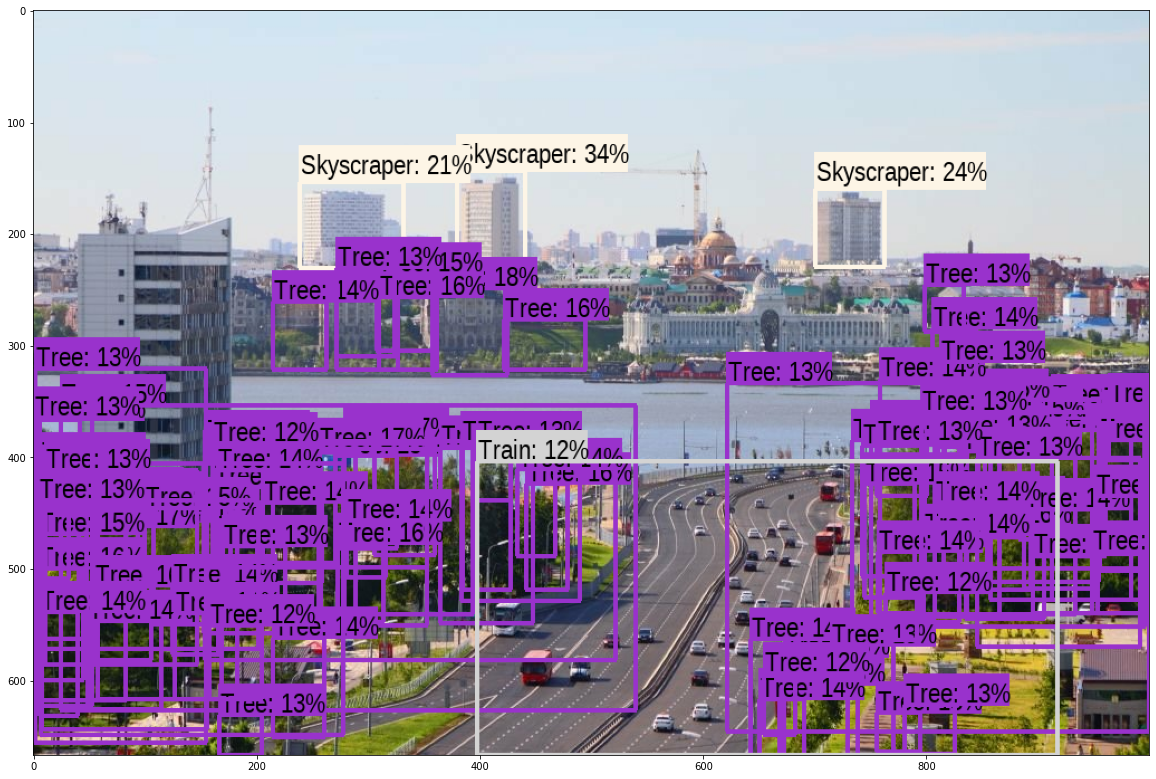

In [32]:
max_frames = 100
result_100 = run_detector(detector, List_name[0])

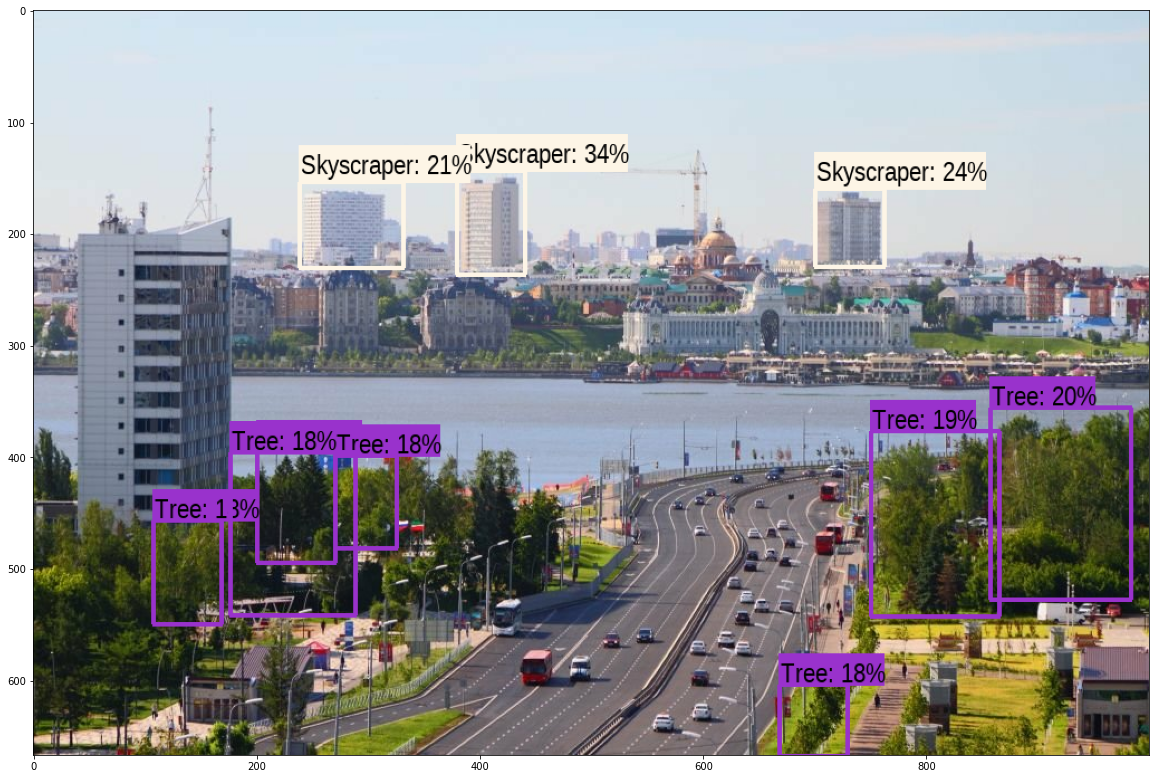

In [34]:
max_frames = 10
result_10 = run_detector(detector, List_name[0])